Now that you have trained an lfads-torch multissession model. Let's walk through how to evaluate the performance of this kind of model using the Rouse reaching dataset introduced in [insert name of prep notebook]. We will do so by testing the generalizability of decoding velocity using the LFADS factors. We will also evaluate PSTHs and state space plots.

In [1]:
import glob, os, h5py, pdb, pickle, copy
import numpy as np
import pandas as pd 
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt 
import matplotlib.cm as colormap
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D
from utils import get_data_from_PSTH_prep, smooth_spikes, get_lfads_output, compute_central_difference, run_five_fold_cv_decoding, evaluate_decoder, plot_firing_rates

In [2]:
DATA_PATH = ['/all/path/to/data/']
OUTPUT_PATH = '/path/to/best_model/folder/in/lfads-torch/run/folder/'
binwidth = 0.02 # s
smooth = True

output_files = sorted(glob.glob(OUTPUT_PATH + '*.h5'))

We will load the LFADS inferred rates and factors for performing validation. Here we will also load the joystick position for evaluating decoding performance.

In [4]:
lfads_rates, lfads_factors = get_lfads_output(output_files,binwidth)

aligned_spikes = {}
conditionIDs = {}
behavior = {}

for path in DATA_PATH:
    aligned_spikes.update(get_data_from_PSTH_prep(path, 'spikes_peakVel', bin_size_s=binwidth))
    conditionIDs.update(get_data_from_PSTH_prep(path, 'conditionID_peakVel', bin_size_s=binwidth))
    behavior.update(get_data_from_PSTH_prep(path, 'JoystickPos_peakVel', bin_size_s=binwidth))

In [5]:
'''
Repeating some data preparation steps
'''

for k in aligned_spikes:
    spks = aligned_spikes[k]
    cnds = conditionIDs[k]
    beh = behavior[k]

    nan_inds = np.unique(np.where(np.isnan(aligned_spikes[k]))[-1])
    keep_trials = set(np.array(range(0, spks.shape[-1]))) - set(nan_inds) #np.unique(np.where(~np.isnan(spks))[-1])
    keep_inds = np.array(list(keep_trials))

    aligned_spikes[k] = spks[:, :, keep_inds]
    conditionIDs[k] = cnds[keep_inds, :]
    behavior[k] = beh[:, :, keep_inds]

smoothed_spikes = smooth_spikes(aligned_spikes, 0.02, binwidth, nanpad=True)

In [6]:
nan_mask = {k: np.isnan(smoothed_spikes[k]) for k in smoothed_spikes}
lfads_rates_masked = copy.deepcopy(lfads_rates)
lfads_factors_masked = copy.deepcopy(lfads_factors)

# apply the nan mask to each day in the lfads_factors and rates 
for k in lfads_factors: 
    lfads_rates_masked[k][nan_mask[k]] = np.nan
    n_factors = lfads_factors[k].shape[0]   
    lfads_factors_masked[k][nan_mask[k][:n_factors,:,:]] = np.nan

In [7]:
# Compute velocity 

velocity = {k: compute_central_difference(behavior[k]) for k in behavior}

In [8]:
'''
Separate out the corrective and non-corrective conditions trials for spikes, lfads factors, and velocity. Condition IDs 1-24 are non-corrective, 25-32 are corrective.
'''

conditionIDs_lim = {}
lfads_factors_lim = {}
velocity_lim = {}
smoothed_spikes_lim = {}

for k in lfads_factors_masked: 
    conds = conditionIDs[k]
    factors = lfads_factors_masked[k]
    vel = velocity[k]
    ss = smoothed_spikes[k]

    include_inds = np.where(conds <= 24)[0]

    conds_incl = conds[include_inds, :]
    factors_incl = factors[:, :, include_inds]
    vel_incl = vel[:, :, include_inds]
    ss_incl = ss[:, :, include_inds]

    conditionIDs_lim[k] = conds_incl
    lfads_factors_lim[k] = factors_incl
    velocity_lim[k] = vel_incl
    smoothed_spikes_lim[k] = ss_incl
 
conditionIDs_corr = {}
lfads_factors_corr = {}
velocity_corr = {}
smoothed_spikes_corr = {}

for k in lfads_factors_masked: 
    conds = conditionIDs[k]
    factors = lfads_factors_masked[k]
    vel = velocity[k]
    ss = smoothed_spikes[k]

    include_inds = np.where(conds > 24)[0]

    conds_incl = conds[include_inds, :]
    factors_incl = factors[:, :, include_inds]
    vel_incl = vel[:, :, include_inds]
    ss_incl = ss[:, :, include_inds]

    conditionIDs_corr[k] = conds_incl
    lfads_factors_corr[k] = factors_incl
    velocity_corr[k] = vel_incl
    smoothed_spikes_corr[k] = ss_incl

Now we will decode the velocity from the LFADS factors by training a separate linear decoder on each session and evaluating the performance on test trials from the same session. This will give us the upper bound of decoding performance for each session, which we will refer to as "Held-In Performance". We will perform this procedure using all trials, only the corrective submovement trials, and only the initial submovement trials. We repeat using smoothed spikes for a reference point.

In [9]:


lf_perfs = {}
lf_perfs['all'] = []
lf_perfs['no_corrective'] = []
lf_perfs['only_corrective'] = []
for ii, k in enumerate(sorted(lfads_factors_masked.keys())): 
    x = {k: lfads_factors_masked[k]}
    y = {k: velocity[k]}

    mvaf, _ = run_five_fold_cv_decoding(x, y, n_lag=5)

    lf_perfs['all'].append(mvaf)

for ii, k in enumerate(sorted(lfads_factors_lim.keys())): 
    x = {k: lfads_factors_lim[k]}
    y = {k: velocity_lim[k]}

    mvaf, _ = run_five_fold_cv_decoding(x, y, n_lag=5)

    lf_perfs['no_corrective'].append(mvaf)

for ii, k in enumerate(sorted(lfads_factors_corr.keys())): 
    x = {k: lfads_factors_corr[k]}
    y = {k: velocity_corr[k]}

    mvaf, _ = run_five_fold_cv_decoding(x, y, n_lag=5)

    lf_perfs['only_corrective'].append(mvaf)

ss_perfs = {}
ss_perfs['all'] = []
ss_perfs['no_corrective'] = []
ss_perfs['only_corrective'] = []
for ii, k in enumerate(sorted(smoothed_spikes.keys())): 
    x = {k: smoothed_spikes[k]}
    y = {k: velocity[k]}

    mvaf, _ = run_five_fold_cv_decoding(x, y, n_lag=5)

    ss_perfs['all'].append(mvaf)

for ii, k in enumerate(sorted(smoothed_spikes_lim.keys())): 
    x = {k: smoothed_spikes_lim[k]}
    y = {k: velocity_lim[k]}

    mvaf, _ = run_five_fold_cv_decoding(x, y, n_lag=5)

    ss_perfs['no_corrective'].append(mvaf)

for ii, k in enumerate(sorted(smoothed_spikes_corr.keys())): 
    x = {k: smoothed_spikes_corr[k]}
    y = {k: velocity_corr[k]}

    mvaf, _ = run_five_fold_cv_decoding(x, y, n_lag=5)

    ss_perfs['only_corrective'].append(mvaf)


Here we want to test how well a linear decoder trained on other sessions' factors generalizes to factors from a held-out session. We train the decoder on N-1 sessions and evaluate the performance on the held-out session. We repeat this for all 12 sessions in the dataset. 

Again we are evaluating on all the trials, only-corrective trials, and initial trials.

In [10]:
n_lag = 5
dates = sorted(lfads_factors_masked.keys())

decode_from = {'all': lfads_factors_masked,
               'no_corrective': lfads_factors_lim,
               'only_corrective': lfads_factors_corr,
               }
held_out_results = {}

for jj, dec in enumerate(sorted(decode_from.keys())): 
    x = decode_from[dec]

    if 'no_corrective' in dec:
        y = velocity_lim
        conds = conditionIDs_lim
    elif 'only_corrective' in dec:
        y = velocity_corr
        conds = conditionIDs_corr
    else: 
        y = velocity
        conds = conditionIDs

    perfs = np.zeros((len(dates)+2, len(dates)))

    for ii, k in enumerate(dates):
        train_k = set(x.keys()) - set([k])
        train_dict_x = {l: x[l] for l in train_k}
        train_dict_y = {l: y[l] for l in train_k}
        
        test_dict_x = {k: x[k]}
        test_dict_y = {k: y[k]}

        _, decoder = run_five_fold_cv_decoding(train_dict_x, train_dict_y, n_lag=n_lag)
        _, mvaf = evaluate_decoder(decoder, train_dict_x, train_dict_y, n_lag=n_lag)
        predictions, performance = evaluate_decoder(decoder, test_dict_x, test_dict_y, n_lag=n_lag)

        for d in range(len(dates)):
            perfs[ii, d] = mvaf[dates[d]] if dates[d] not in k else performance[dates[d]]

        perfs[-2, ii] = lf_perfs[dec][ii]
        perfs[-1, ii] = ss_perfs[dec][ii]

    held_out_results[dec] = perfs

We will plot the above results as a bar plot. 

If the model successfully found a common set of dynamics that describe all sessions, the held-out performance should be close to the held-in performance. Additionally, we expect the decoding performance from LFADS factors to exceed that of smoothed spikes.

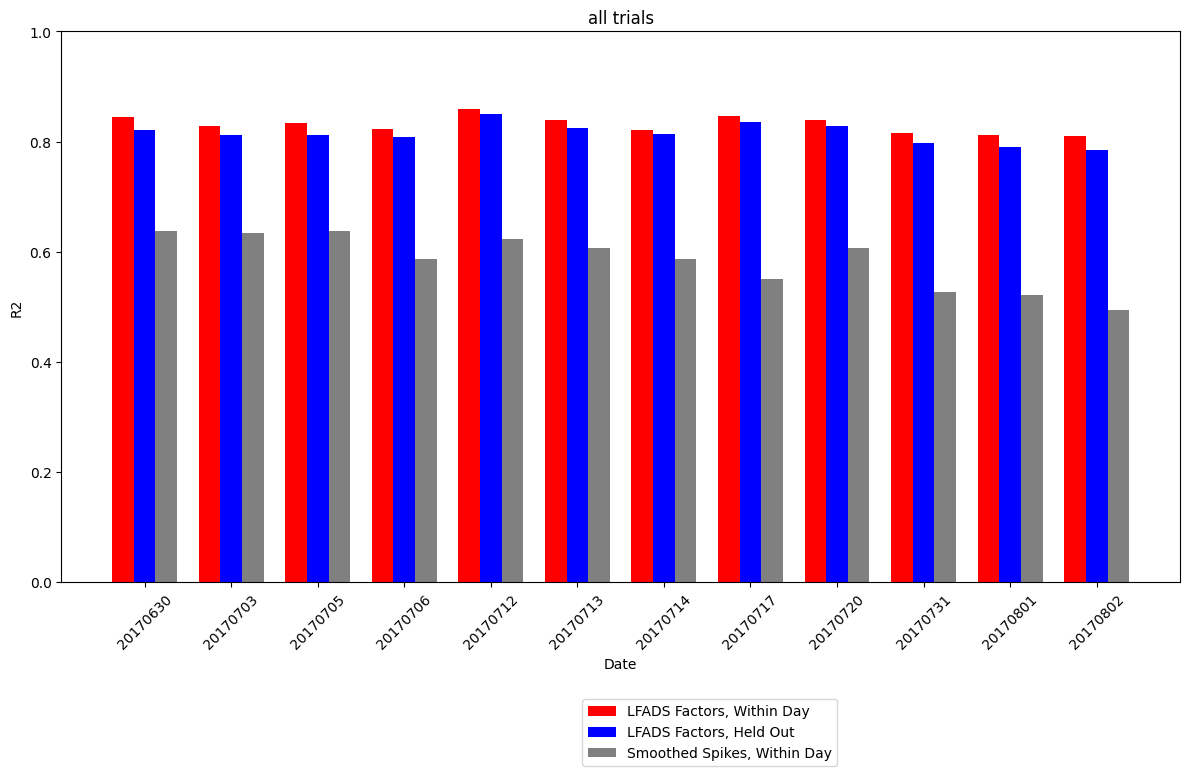

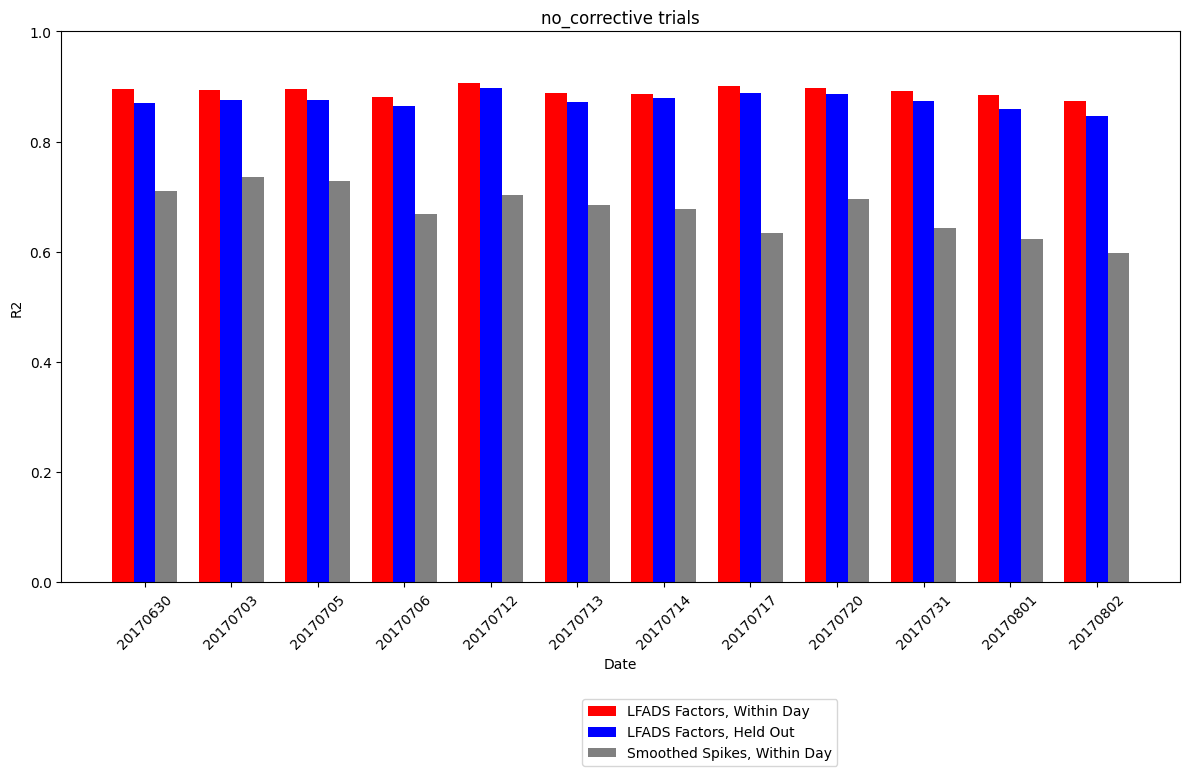

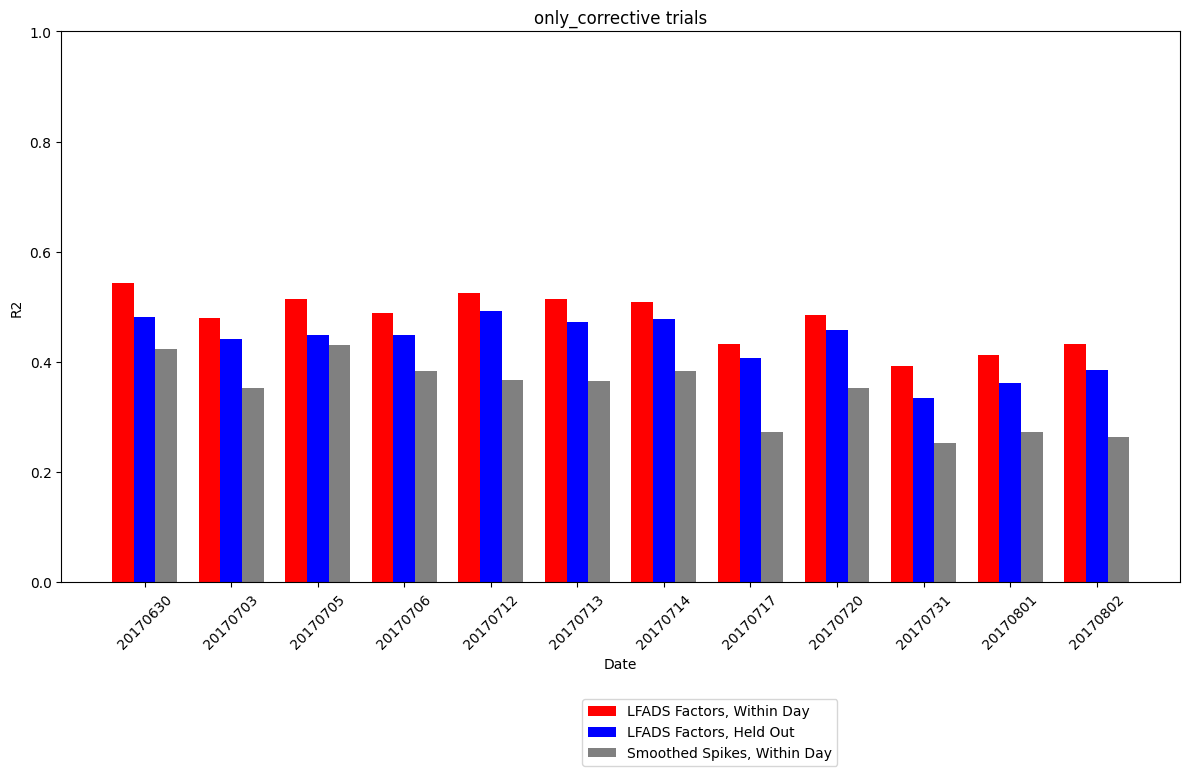

In [11]:
num_ds = len(dates)
for dec in held_out_results:
    perfs = held_out_results[dec]
    plt.figure(figsize=(num_ds, 8))
    labels = dates 
    x = np.arange(len(labels))
    width = 0.25
    positions = [-1, 0, 1]

    # held in performance
    rects1 = plt.bar(x - width, perfs[-2, :], width, label='LFADS Factors, Within Day', color='r')
    # held out performance 
    rects2 = plt.bar(x, perfs[np.diag_indices(num_ds)], width, label='LFADS Factors, Held Out', color='b')
    # smoothed spikes 
    rects3 = plt.bar(x + width, perfs[-1,:], width, label='Smoothed Spikes, Within Day', color='gray')

    plt.ylabel('R2')
    plt.ylim([0, 1.])
    ax = plt.gca()
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.set_xlabel('Date')
    ax.legend(bbox_to_anchor=(0.7, -0.2), ncol=1)
    ax.set_title(dec + ' trials')
    plt.xticks(rotation=45)
    plt.tight_layout()

Lastly we will plot the state-space plot of the LFADS factors for each session in a 3D space by fitting PCA across all the sessions and then transforming each session individually. All the sessions should look similar to each other if the LFADS factors have generalized well across all the sessions. 
For the sake of visualization, here we will take only the initial trials.

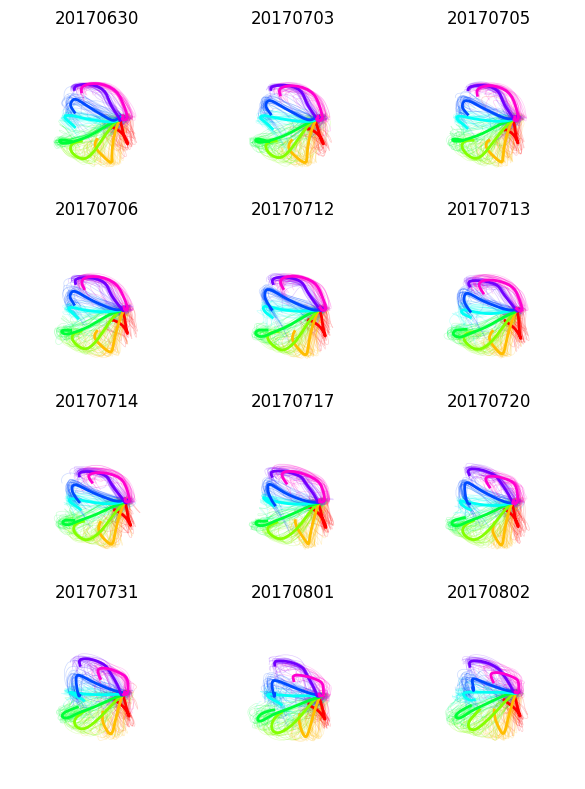

In [12]:
conditionIDs_lim = {}
lfads_factors_lim = {}

for k in lfads_factors: 
    conds = conditionIDs[k]
    factors = lfads_factors[k]

    include_inds = np.where(conds <= 24)[0]

    conds_incl = conds[include_inds, :]
    factors_incl = factors[:, :, include_inds]

    conditionIDs_lim[k] = conds_incl
    lfads_factors_lim[k] = factors_incl

fig = plt.figure(figsize=(6, 8))
locations = [431, 432, 433, 434, 435, 436, 437, 438, 439]
axes = []
for l in locations:
    ax = fig.add_subplot(l, projection='3d')
    axes.append(ax)
ax = fig.add_subplot(4, 3, 10, projection='3d')
axes.append(ax)
ax = fig.add_subplot(4, 3, 11, projection='3d')
axes.append(ax)
ax = fig.add_subplot(4, 3, 12, projection='3d')
axes.append(ax)

field_to_plot = lfads_factors_lim
cond_field_to_plot = conditionIDs_lim

keys = sorted([k for k in field_to_plot])
cm = colormap.hsv
pca = PCA(n_components=3)

# combine all data to fit PCA 
all_days_data = []
for k in keys: 
    data = field_to_plot[k]
    data_reshaped = np.vstack(np.swapaxes(data, 0, 2)) #(trials x time) x factors
    all_days_data.append(data_reshaped)

pca_input = np.vstack(all_days_data)
ss = StandardScaler()
pca.fit(ss.fit_transform(pca_input))

# fit PCA on each dataset individually
for ii, k in enumerate(keys):
    ss = StandardScaler()
    data = field_to_plot[k] #factors x time x trials
    time = data.shape[1]
    trials = data.shape[2]
    data_reshaped = np.vstack(np.swapaxes(data, 0, 2)) #(trials x time) x factors
  
    data_reduced = pca.transform(ss.fit_transform(data_reshaped))

    # reshape the reduced data 
    data_reduced_reshaped = np.reshape(data_reduced, (trials, time, 3))

    conditions = copy.deepcopy(cond_field_to_plot[k])
    for c in conditions: 
        if c > 24: 
            c -= 24
        elif c > 16: 
            c -= 16
        elif c > 8: 
            c -= 8
    n_conds = len(np.unique(conditions))

    for jj in range(n_conds):
        where_cond = np.where(conditions == jj+1)[0]
        trials_cond = data_reduced_reshaped[where_cond, :, :]

        for tt in range(30):
            axes[ii].plot(trials_cond[tt, :, 0], 
                trials_cond[tt, :, 1], 
                trials_cond[tt, :, 2], 
                color=cm(float(jj)/n_conds),
                alpha=0.2,
                linewidth=0.5)
    # plot trial average 
    for jj in range(n_conds):
        where_cond = np.where(conditions == jj+1)[0]
        trials_cond = data_reduced_reshaped[where_cond, :, :]

        trial_avg_cond = np.mean(trials_cond, axis=0)
        axes[ii].plot(trial_avg_cond[:, 0], 
                trial_avg_cond[:, 1], 
                trial_avg_cond[:, 2], 
            color=cm(float(jj)/n_conds),
            alpha=1,
            linewidth=2)
    axes[ii].view_init(elev=15., azim=37.5)
    axes[ii].grid(False)
    axes[ii].axis('off')
    axes[ii].set_title(k)
    axes[ii].set_xlabel('PC1')
    axes[ii].set_ylabel('PC2')
    axes[ii].set_zlabel('PC3')
    fig.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)


As an additional check, we can plot the PSTHs of the LFADS rates to verify if they are comparable to the empirical PSTHs obtained using smoothed spikes.
For simplicity, we do this for a single session and 20 neurons below.

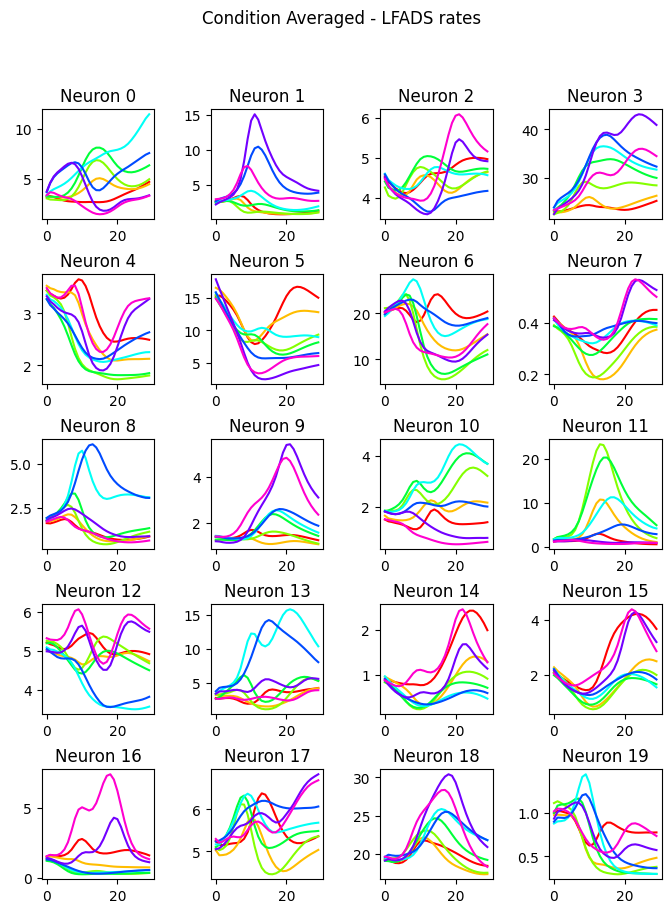

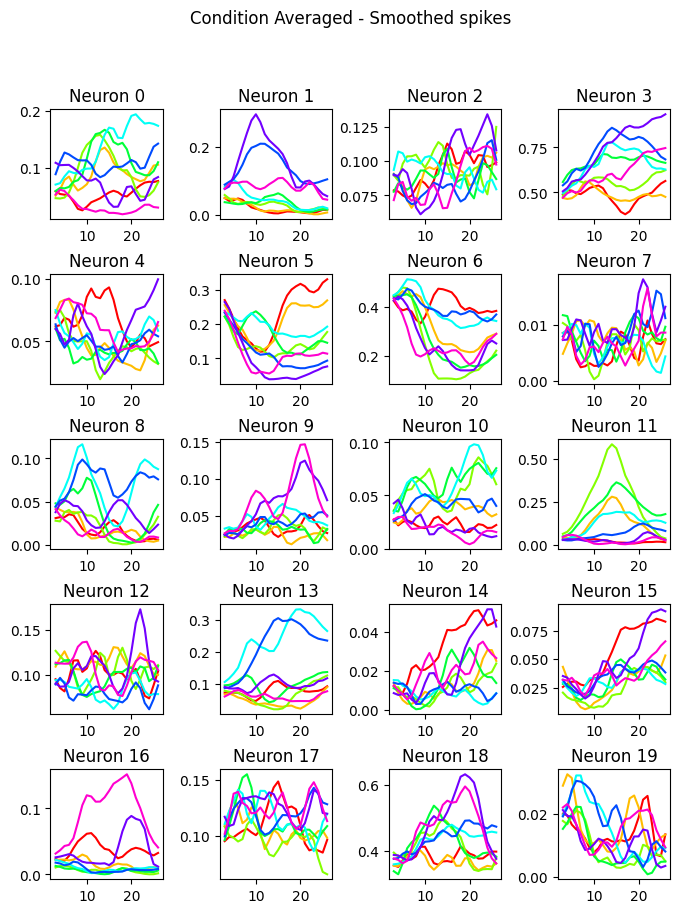

In [13]:
session = '20170705'
plot_firing_rates(lfads_rates[session], conditionIDs[session], 'LFADS Rates', neurons=np.arange(0, 20))
plot_firing_rates(smoothed_spikes[session], conditionIDs[session], 'Smoothed Spikes', neurons=np.arange(0, 20))

We have now successfully trained and evaluated a multisession lfads-torch model! You can modify these notebooks to prepare, train, and evaluate your own data for multisession models. 